In [2]:
import bisect
import math
import os
import cv2
import h5py
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [3]:
hdf5_dir = "/Users/emanuelwreeby/Plugg/Terminer/Exjobb/src/data/univrses"

In [4]:
filename = os.path.join(hdf5_dir, "record_2022-04-22_07-17-55.hdf5")
sequence_f = h5py.File(filename, "r")
print("Keys: %s" % sequence_f.keys())
print("version",sequence_f.attrs['3DAI_version'])

Keys: <KeysViewHDF5 ['Accelerometer', 'CameraModel', 'Detection', 'FusionTimestampedPose', 'GeoLocation', 'Gyroscope', 'YUV420 Images']>
version 2


In [5]:
print("Images", sequence_f["YUV420 Images"].attrs.keys())

Images <KeysViewHDF5 ['image_height', 'image_width', 'u_start', 'uv_pixel_stride', 'uv_row_stride', 'v_start', 'y_row_stride']>


In [6]:
print(sequence_f["CameraModel"].attrs.keys())

<KeysViewHDF5 ['cx', 'cy', 'fx', 'fy', 'image_height', 'image_width', 'k1', 'k2', 'p1', 'p2']>


In [9]:
first_timestamp = math.inf
last_timestamp = -math.inf
image_timestamps = []

for image in tqdm.tqdm(sequence_f['YUV420 Images']):
    first_timestamp = min(first_timestamp, image["timestamp"])
    last_timestamp = max(last_timestamp, image["timestamp"])
    image_timestamps.append(image["timestamp"])

print(first_timestamp, last_timestamp)

100%|██████████| 7915/7915 [00:07<00:00, 995.67it/s] 

659517232112 922662943447


In [10]:
def get_image_at_timestamp(query_timestamp):
    image_idx = bisect.bisect_left(image_timestamps, query_timestamp)
    assert(image_timestamps[image_idx] == query_timestamp)
    image_byte_array_yuv = sequence_f['YUV420 Images'][image_idx]["bytes"]
    image_width=1280
    image_height=720

    '''
    YUV420 with interleaved U and V , with uv_row_stride = y_row_stride = image_width.
    For more details look at N12 or N21: https://www.fourcc.org/pixel-format/yuv-nv12/
    '''
    e = image_width * image_height
    Y = image_byte_array_yuv[0:e]
    Y = np.reshape(Y, (image_height, image_width))
    V = image_byte_array_yuv[e::2]
    V = np.repeat(V, 2, 0)
    V = np.reshape(V, (int(image_height/2), image_width))
    V = np.repeat(V, 2, 0)
    U = image_byte_array_yuv[e+1::2]
    U = np.repeat(U, 2, 0)
    U = np.reshape(U, (int(image_height/2), image_width))
    U = np.repeat(U, 2, 0)

    RGBMatrix = (np.dstack([Y,U,V])).astype(np.uint8)
    RGBMatrix = cv2.cvtColor(RGBMatrix, cv2.COLOR_YUV2RGB, 3)
    return RGBMatrix

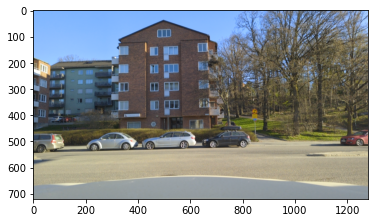

In [11]:
# Show one image
plt.figure()
plt.imshow(get_image_at_timestamp(image_timestamps[300]))
plt.show()

In [12]:
# Load vehicle detections
vehicle_filename = os.path.join(hdf5_dir, "record_2022-04-22_07-17-55_vehicle_detections.hdf5")
vehicle_sequence_f = h5py.File(vehicle_filename, "r")
print("Keys: %s" % vehicle_sequence_f.keys())

Keys: <KeysViewHDF5 ['Detection']>


In [13]:
detections = []
print("Loading detections ...")

for d in tqdm.tqdm(list(vehicle_sequence_f['Detection'])):
    # print(d)
    detections.append({"timestamp":int(d[0]), "type":d[1], "uuid":d[2], 
                      "confidence":d[3], "top":d[4], "bottom":d[5],
                      "left":d[6], "right":d[7]})

Loading detections ...


100%|██████████| 17562/17562 [00:00<00:00, 165515.15it/s]


In [17]:
detections[:10]

[{'timestamp': 659517232112,
  'type': 32,
  'uuid': array([0, 1]),
  'confidence': 0.703125,
  'top': 437,
  'bottom': 606,
  'left': 645,
  'right': 1050},
 {'timestamp': 659517232112,
  'type': 29,
  'uuid': array([0, 2]),
  'confidence': 0.640625,
  'top': 459,
  'bottom': 501,
  'left': 293,
  'right': 363},
 {'timestamp': 659583724787,
  'type': 29,
  'uuid': array([0, 3]),
  'confidence': 0.88671875,
  'top': 457,
  'bottom': 500,
  'left': 296,
  'right': 367},
 {'timestamp': 659583724787,
  'type': 29,
  'uuid': array([0, 4]),
  'confidence': 0.62109375,
  'top': 454,
  'bottom': 502,
  'left': 157,
  'right': 277},
 {'timestamp': 659583724787,
  'type': 32,
  'uuid': array([0, 5]),
  'confidence': 0.62109375,
  'top': 437,
  'bottom': 602,
  'left': 653,
  'right': 1062},
 {'timestamp': 659616971125,
  'type': 29,
  'uuid': array([0, 6]),
  'confidence': 0.85546875,
  'top': 454,
  'bottom': 499,
  'left': 293,
  'right': 368},
 {'timestamp': 659616971125,
  'type': 29,
  'uu

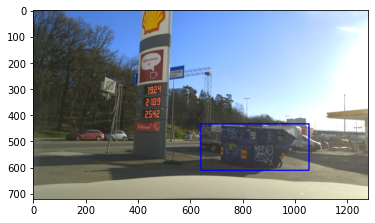

In [20]:
# show detection bounding box
d = detections[0]
img = get_image_at_timestamp(d["timestamp"])
#print(d["top"],d["bottom"],d["left"],d["right"])
cv2.rectangle(img, (d["left"]-4,d["top"]-4), (d["right"]+4, d["bottom"]+4), (0, 0, 255),4)
plt.figure()
plt.imshow(img)
plt.show()

In [77]:
#Plot GPS

In [78]:
positions = []
for d in tqdm.tqdm(list(sequence_f['GeoLocation'])):
    positions.append({"timestamp":int(d[0]), "latitude":d[1], "longitude":d[2], 
                      "altitude":d[3], "speed":d[4], "horizontal_accuracy":d[5],
                      "vertical_accuracy":d[6], "speed_accuracy":d[7]})

100%|█████████████████████████████████████| 260/260 [00:00<00:00, 435336.94it/s]


In [79]:
import folium

traj_map = folium.Map(max_zoom=20, control_scale=True)
traj_map.location = [positions[0]['latitude'], positions[0]['longitude']]
traj_map.options['zoom'] = 16


trajectory = folium.vector_layers.PolyLine(
    locations=[
        (p['latitude'],
        p['longitude']) for p in positions]
)
trajectory.add_to(traj_map)
traj_map

In [13]:
sequence_f['FusionTimestampedPose'][0]

(673691943889, [ 5.05798767, -0.07341572, -0.04665806,  0.03124364, -0.01885417,  0.16197518], 675864107580)

In [8]:
import jaxlie
fused_positions = []
for d in tqdm.tqdm(list(sequence_f['FusionTimestampedPose'])):
    print(d)
    fused_positions.append(jaxlie.SE3.exp(d[1]).translation())
    break

fused_positions = np.array(fused_positions)

fig = go.Figure(data=go.Scatter3d(
x=fused_positions[:,0], y=fused_positions[:,1], z=fused_positions[:,2], mode="lines"))
fig.update_layout(scene=dict(aspectmode='data'))
fig.show()

  0%|          | 0/5155 [00:00<?, ?it/s]

(673691943889, [ 5.05798767, -0.07341572, -0.04665806,  0.03124364, -0.01885417,  0.16197518], 675864107580)


NameError: name 'go' is not defined